# 11wk-2: Choropleth (plotly)

최규빈  
2023-11-15

<a href="https://colab.research.google.com/github/guebin/DV2023/blob/main/posts/11wk-2.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

<https://youtu.be/playlist?list=PLQqh36zP38-yEy-v8Q0fD5G7f1k0uuVDj&si=nkPFXHmYLwq2-fo2>

# 2. Imports

In [1]:
# !conda install -c conda-forge plotly

In [2]:
import numpy as np
import pandas as pd
#---#
import plotly.express as px
import json 
import requests 

# 3. 에너지사용량 시각화

## A. 데이터 불러오기

In [3]:
global_dict = json.loads(requests.get('https://raw.githubusercontent.com/southkorea/southkorea-maps/master/kostat/2018/json/skorea-provinces-2018-geo.json').text)
local_dict = json.loads(requests.get('https://raw.githubusercontent.com/southkorea/southkorea-maps/master/kostat/2018/json/skorea-municipalities-2018-geo.json').text)
#--#
url = 'https://raw.githubusercontent.com/guebin/DV2022/main/posts/Energy/{}.csv'
prov = ['Seoul', 'Busan', 'Daegu', 'Incheon', 
        'Gwangju', 'Daejeon', 'Ulsan', 'Sejongsi', 
        'Gyeonggi-do', 'Gangwon-do', 'Chungcheongbuk-do', 
        'Chungcheongnam-do', 'Jeollabuk-do', 'Jeollanam-do', 
        'Gyeongsangbuk-do', 'Gyeongsangnam-do', 'Jeju-do']
df = pd.concat([pd.read_csv(url.format(p+y)).assign(년도=y, 시도=p) for p in prov for y in ['2018', '2019', '2020', '2021']]).reset_index(drop=True)\
.assign(년도 = lambda df: df.년도.astype(int))\
.set_index(['년도','시도','지역']).applymap(lambda x: int(str(x).replace(',','')))\
.reset_index()
df.head()

/tmp/ipykernel_2852986/712135142.py:12: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.


## B. 데이터정리

`(1)` `global_dict` 내의 영어이름과 `df`의 영어이름이 일치하는지 확인

In [4]:
set(df.시도) == {l['properties']['name_eng'] for l in global_dict['features']}

`(2)` `global_dict`내의 영어이름과 한글이름을 이용해 변환을 위한
dictionary 생성

In [5]:
{l['properties']['name_eng']:l['properties']['name'] for l in global_dict['features']}

`(3)` `df`에 변환을 수행하여 영어지명을 한글지명으로 변환

In [6]:
df.assign(
    시도 = lambda df: df.시도.map({l['properties']['name_eng']:l['properties']['name'] for l in global_dict['features']})
)

`(4)` `local_dict`와 `global_dict`의 지명정보를 정리하여
데이터프레임으로 만듦

`# 예비학습`

In [7]:
pd.DataFrame(
    [{'X':100,'y':0},
     {'X':101,'y':1}]
)    

`#`

In [8]:
df_global = pd.DataFrame([l['properties'] for l in global_dict['features']])
df_global

In [9]:
df_local = pd.DataFrame([l['properties'] for l in local_dict['features']])
df_local

`(5)` `df_local`에서 “전주시완산구”와 같이 정리된 지명들을 “완산구”로
변환

In [10]:
df_local.set_index('name')\
.rename(
    {name:name.split('시')[-1] for name in df_local['name'] if ('시' in name) and ('구' in name) and (len(name)>3)}
).reset_index()

`(6)` `df_local`과 `df_global`의 정보를 정리하여 merge, 합쳐진 정보를
`df_json`에 저장

In [11]:
df_json = df_local.set_index('name')\
.rename(
    {name:name.split('시')[-1] for name in df_local['name'] if ('시' in name) and ('구' in name) and (len(name)>3)}
).reset_index()\
.drop(['base_year','name_eng'],axis=1)\
.rename({'name':'name_local','code':'code_local'},axis=1)\
.assign(code = lambda df: df['code_local'].str[:2])\
.merge(df_global.drop(['base_year','name_eng'],axis=1))
df_json

`(7)` df_json과 df의 정보를 merge하기 위하여 ’서울특별시-종로구’와 같은
형식으로 공통열을 각각 생성. 생성된 공통열의 원소가 일치하는지 비교

In [12]:
df_left = df.assign(
    시도 = lambda df: df.시도.map({l['properties']['name_eng']:l['properties']['name'] for l in global_dict['features']})
).assign(on = lambda df: df.시도 + '-' + df.지역)
df_left

In [13]:
df_right = df_json.assign(on = lambda df: df.name + '-' + df.name_local)\
.drop(['name_local','name'],axis=1)
df_right

In [14]:
set(df_left.on) == set(df_right.on)

In [15]:
set(df_right.on) - set(df_left.on)

In [16]:
set(df_left.on) - set(df_right.on)

`(8)` 아래의 기사를 살펴보고 지역명을 적절히 변환

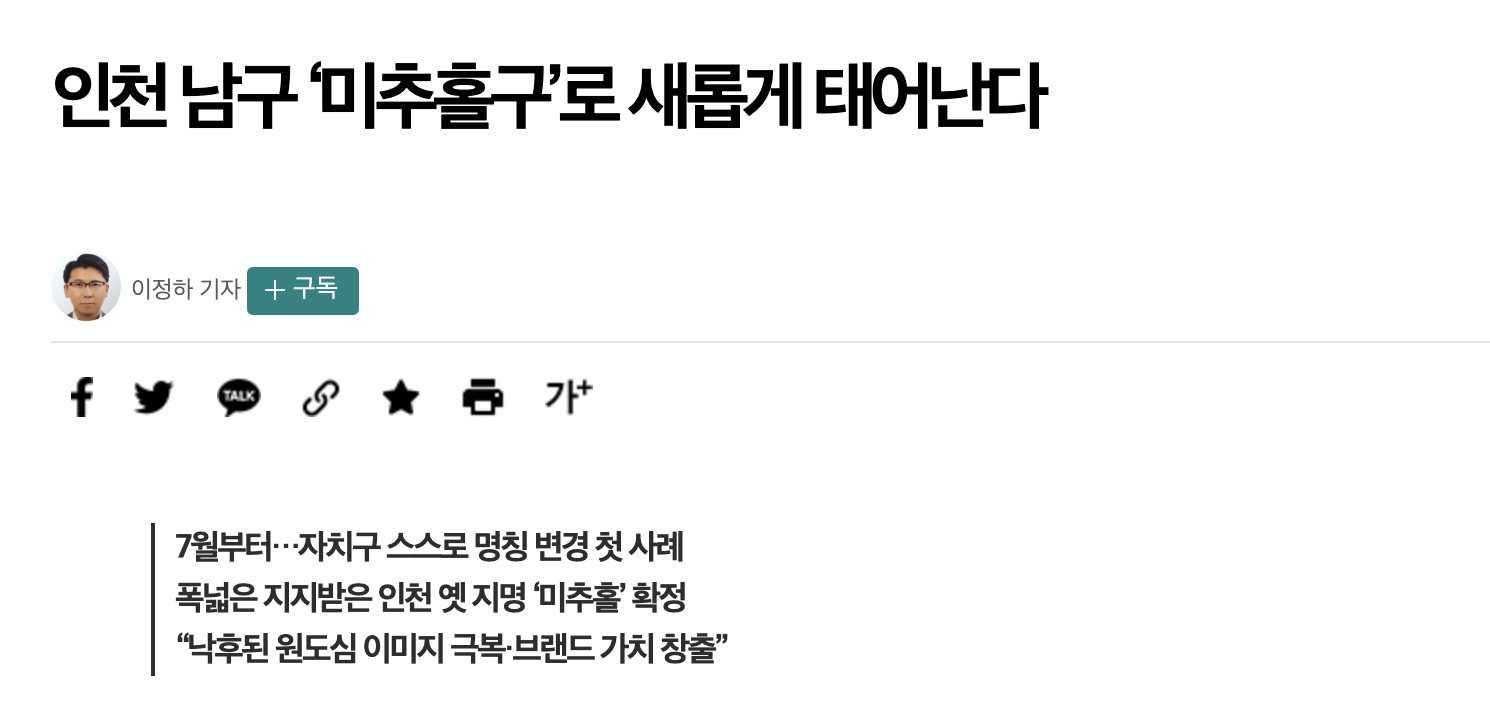

-   <https://www.hani.co.kr/arti/area/area_general/834359.html>

In [17]:
df_right.set_index('on')\
.rename({'인천광역시-남구':'인천광역시-미추홀구'})\
.reset_index()

`(9)` 데이터프레임을 결합

In [18]:
df2 = df_left.merge(
    df_right.set_index('on')\
    .rename({'인천광역시-남구':'인천광역시-미추홀구'})\
    .reset_index()
).drop(['on'],axis=1)

## C. 시각화 (2018년도 전기에너지 사용량)

In [19]:
df2

In [20]:
px.choropleth_mapbox(
    geojson = local_dict,
    featureidkey = 'properties.code',
    data_frame = df2.query('년도 == 2018'),
    locations = 'code_local',
    color = '에너지사용량(TOE)/전기',
    hover_data = ['시도','지역'],
    #---#
    mapbox_style="carto-positron",
    center={"lat": 36, "lon": 127.5}, 
    zoom=6,
    height=800,
    width=800    
)

## D. 시각화 (2018~2021년도 전기에너지 사용량)

In [21]:
seoul_dict = local_dict.copy() 
seoul_dict['features'] = [l for l in seoul_dict['features'] if l['properties']['code'][:2] == '11']

In [22]:
px.choropleth_mapbox(
    geojson = seoul_dict,
    featureidkey = 'properties.code',
    data_frame = df2,
    locations = 'code_local',
    color = '에너지사용량(TOE)/전기',
    animation_frame= '년도',
    hover_data = ['시도','지역'],
    #---#
    mapbox_style="carto-positron",
    range_color = [0,400000],
    center={"lat": 37.5642135, "lon": 127.0016985},
    zoom=9,
    height=500,
    width=700    
)

# 4. HW

2018~2021년도 대전의 전기에너지 사용량을 애니메이션으로 시각화